<a href="https://colab.research.google.com/github/JahnaviRamagiri/EVA-B2/blob/master/S11_superconvergence/S11_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install Packages

In [2]:
!pip install albumentations==0.4.5 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.1/116.1 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.4/631.4 kB 40.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# Memory Information

In [3]:
%cd /content/drive/MyDrive/Fellowship AI/S11_superconvergence

/content/drive/MyDrive/Fellowship AI/S11_superconvergence


In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 25.45GB
Available: 24.33GB
Used: 771.60MB
Percentage: 4.4%


# GPU Information

In [ ]:
!nvidia-smi

Sun Jun 25 23:16:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Packages

In [4]:
import os
import cv2
import numpy as np
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as alb
from albumentations.pytorch import ToTensor

In [5]:
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchsummary import summary
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import OneCycleLR #ReduceLROnPlateau


In [6]:
from Model.Custom_RESNET import model_custom_ResNET
from Packages.augmentation import Flowers102_AlbumTrans, FLOWERS102_Transforms
from Packages.data import FLOWER102DataLoader
from Packages.data_summary import model_summary, display
from Packages.constants import CLASSES
from Packages.test import Test
from Packages.train import Train
from Packages.lr_finder import LRFinder
from Packages.statistics import *

/content/drive/MyDrive/Fellowship AI/S11_superconvergence/Packages/lr_finder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
  pip install torch-lr-finder -v --global-option="amp"


# Dataset

In [ ]:
# Load the MAT-file
mat = scipy.io.loadmat('/content/drive/MyDrive/Fellowship AI/S11_superconvergence/data/flowers-102/imagelabels.mat')
# setid = scipy.io.loadmat('/content/drive/MyDrive/Fellowship AI/S11_superconvergence/data/flowers-102/setid.mat')

In [ ]:
flower_df = pd.DataFrame({"Flower ID" : list(range(1,8190)), "Label ID" : mat['labels'][0]})
flower_df["Class"] = flower_df['Label ID'].map(lambda x: CLASSES[x-1])
flower_df["ID"] = flower_df["Flower ID"].apply(lambda x: '{:05d}'.format(x))

In [ ]:
flower_df.head()

Flower ID  Label ID           Class     ID
0          1        77  Passion Flower  00001
1          2        77  Passion Flower  00002
2          3        77  Passion Flower  00003
3          4        77  Passion Flower  00004
4          5        77  Passion Flower  00005

In [ ]:
get_flower_count(flower_df)

Class Counts:
Petunia                     258
Passion Flower              251
Wallflower                  196
Water Lily                  194
Watercress                  184
                           ... 
Moon Orchid                  40
Bolero Deep Blue             40
Mexican Aster                40
Pink Primrose                40
Prince Of Wales Feathers     40
Name: Class, Length: 102, dtype: int64

Total Flowers: 8189
Unique Classes: 102


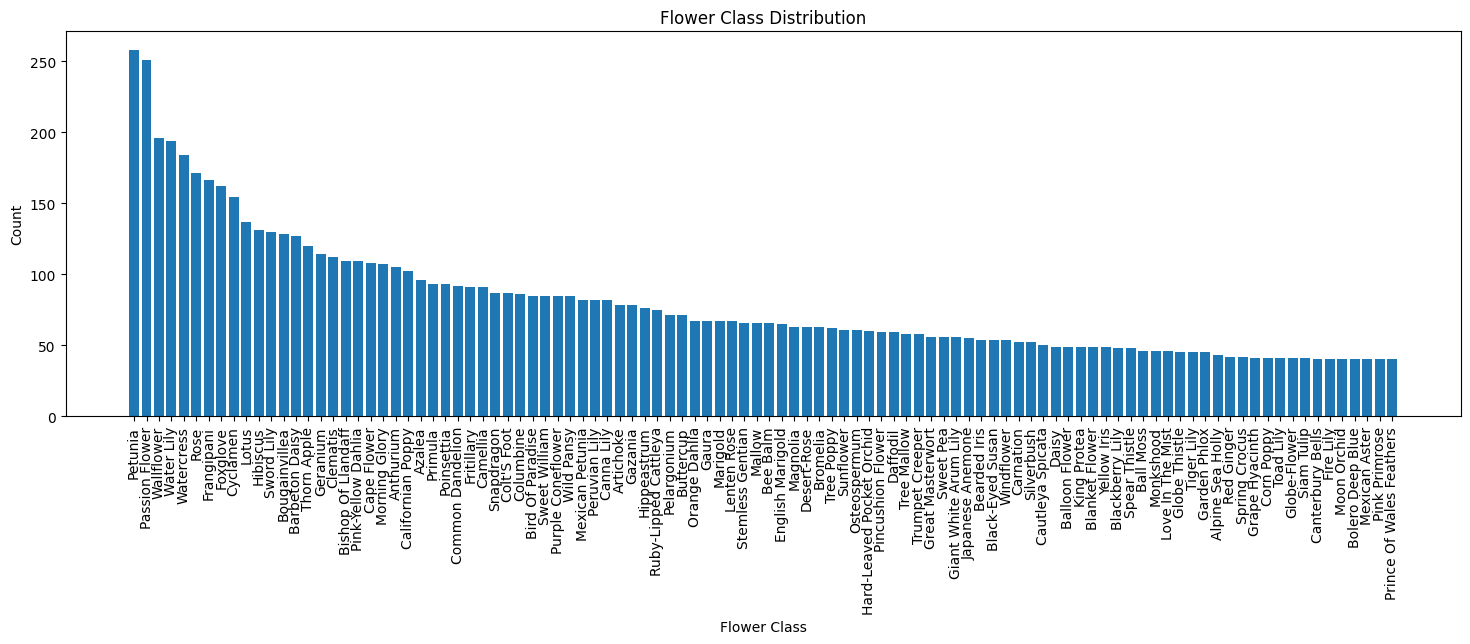

In [ ]:
get_class_distribution(flower_df)

In [ ]:
# df_stats = get_stats(flower_df, "/content/drive/MyDrive/Fellowship AI/S11_superconvergence")

In [ ]:
# plot_stats(df_stats)

In [ ]:
# df_stats.head()

In [ ]:
# show_image_classes(flower_df)

# Dataset and Transformations

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

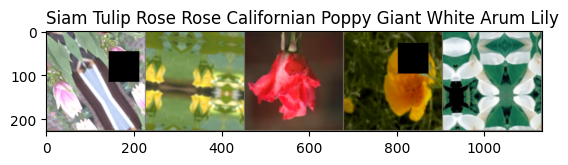

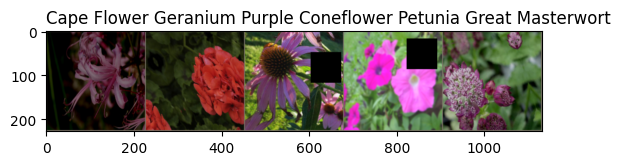

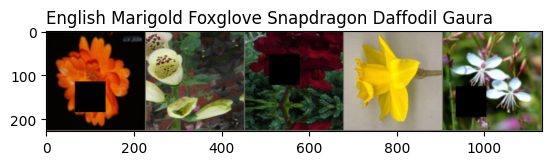

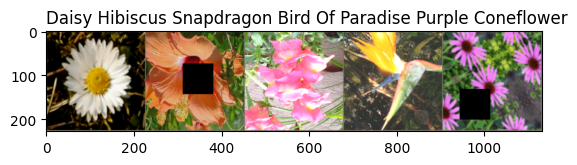

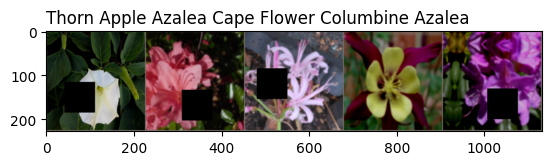

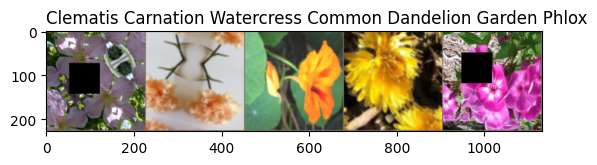

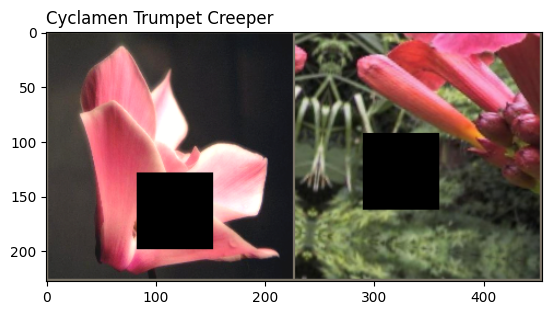

In [9]:
tr_trans = [
              alb.Resize(height=224, width=224),
              alb.ShiftScaleRotate(shift_limit=0.4, scale_limit=0.5, rotate_limit=45, p=0.5),
              alb.GaussianBlur(blur_limit=(3, 7), p=0.5),
              alb.HorizontalFlip(p= 0.75),
              alb.GaussNoise(var_limit=(0.01, 0.1), p=0.5),
              alb.VerticalFlip(p=0.5),
              alb.RandomBrightnessContrast (brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=0.5),
              alb.CenterCrop(224,224, always_apply= True),
              alb.CoarseDropout(max_holes=1, max_height=70, max_width=70, p=0.5),
              alb.Normalize(
                  mean=[0.485, 0.456, 0.406],
                  std=[0.229, 0.224, 0.225]
              ),
              ToTensor()
              ]

trans = Flowers102_AlbumTrans(tr_trans)
data = FLOWER102DataLoader(trans, batch_size=32)
train_loader, test_loader = data.get_loaders()
display(train_loader, 32)

In [ ]:
len(train_loader)

193

In [ ]:
model = model_custom_ResNET()
model = model.to(device)
model_summary(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 310MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

## One-Cycle Policy -- LR Finder

In [ ]:
wt_decay = 1e-3
mom = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-6, nesterov=True, weight_decay=wt_decay, momentum = mom)
optimizer.scheduler = None
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=0.1, num_iter=10 * len(train_loader), step_mode="exp")

  0%|          | 0/1930 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()


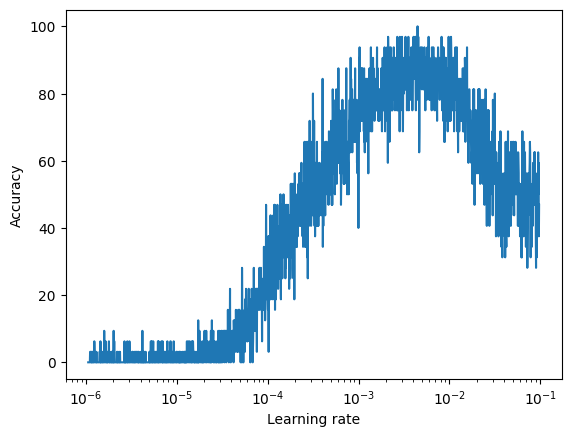

Best acc 100.0
Best LR:  0.0044623060896289615


In [ ]:
lr_finder.plot(plot_case="acc")
best_lr = lr_finder.get_best_lr(case="acc")

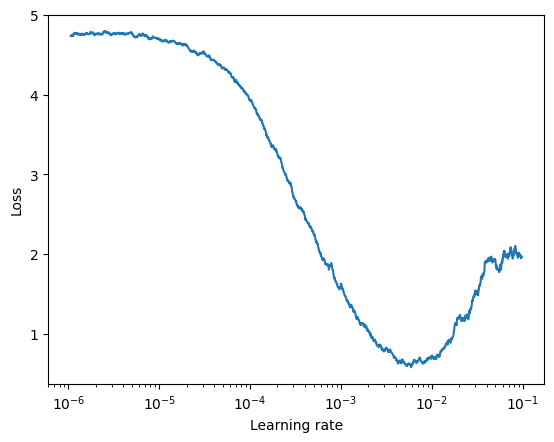

Best loss 0.5829291332070038
Best LR:  0.005907233485743725


In [ ]:
lr_finder.plot(plot_case="loss")
best_loss_lr = lr_finder.get_best_lr(case="loss")

In [ ]:
best_lr

0.0044623060896289615

In [ ]:
lr_finder.reset()

## Model Training

====================START====================
==================== EPOCH: 1 ====================


Loss=4.403262138366699 Batch_id=192 Accuracy=7.95: 100%|██████████| 193/193 [00:47<00:00,  4.10it/s]


 Current LR: 0.00013944706530090532



Test set: Average loss: 0.1267, Accuracy: 181/1020 (17.75%)

==================== EPOCH: 2 ====================


Loss=1.6902873516082764 Batch_id=192 Accuracy=47.32: 100%|██████████| 193/193 [00:46<00:00,  4.13it/s]


 Current LR: 0.0007725151123570179



Test set: Average loss: 0.0706, Accuracy: 530/1020 (51.96%)

==================== EPOCH: 3 ====================


Loss=1.9257739782333374 Batch_id=192 Accuracy=73.33: 100%|██████████| 193/193 [00:48<00:00,  4.01it/s]


 Current LR: 0.0023008765774649334



Test set: Average loss: 0.0289, Accuracy: 839/1020 (82.25%)

==================== EPOCH: 4 ====================


Loss=1.0678718090057373 Batch_id=192 Accuracy=86.23: 100%|██████████| 193/193 [00:47<00:00,  4.09it/s]


 Current LR: 0.003829238042572849



Test set: Average loss: 0.0133, Accuracy: 923/1020 (90.49%)

==================== EPOCH: 5 ====================


Loss=1.161934733390808 Batch_id=192 Accuracy=91.61: 100%|██████████| 193/193 [00:47<00:00,  4.08it/s]


 Current LR: 0.0044623060896289615



Test set: Average loss: 0.0086, Accuracy: 966/1020 (94.71%)

==================== EPOCH: 6 ====================


Loss=0.2412610501050949 Batch_id=192 Accuracy=93.66: 100%|██████████| 193/193 [00:47<00:00,  4.09it/s]


 Current LR: 0.004432827008296154



Test set: Average loss: 0.0069, Accuracy: 963/1020 (94.41%)

==================== EPOCH: 7 ====================


Loss=0.3760364055633545 Batch_id=192 Accuracy=95.19: 100%|██████████| 193/193 [00:47<00:00,  4.05it/s]


 Current LR: 0.004345193876790263



Test set: Average loss: 0.0062, Accuracy: 974/1020 (95.49%)

==================== EPOCH: 8 ====================


Loss=0.22984623908996582 Batch_id=192 Accuracy=96.19: 100%|██████████| 193/193 [00:47<00:00,  4.09it/s]


 Current LR: 0.004201797098496243



Test set: Average loss: 0.0052, Accuracy: 981/1020 (96.18%)

==================== EPOCH: 9 ====================


Loss=0.304937481880188 Batch_id=192 Accuracy=96.31: 100%|██████████| 193/193 [00:47<00:00,  4.07it/s]


 Current LR: 0.004006548163718453



Test set: Average loss: 0.0047, Accuracy: 984/1020 (96.47%)

==================== EPOCH: 10 ====================


Loss=0.47556862235069275 Batch_id=192 Accuracy=97.11: 100%|██████████| 193/193 [00:47<00:00,  4.03it/s]


 Current LR: 0.003764772954421645



Test set: Average loss: 0.0042, Accuracy: 996/1020 (97.65%)

==================== EPOCH: 11 ====================


Loss=0.8073602914810181 Batch_id=192 Accuracy=97.24: 100%|██████████| 193/193 [00:47<00:00,  4.06it/s]


 Current LR: 0.0034830664680545044



Test set: Average loss: 0.0043, Accuracy: 988/1020 (96.86%)

==================== EPOCH: 12 ====================


Loss=0.5472842454910278 Batch_id=192 Accuracy=97.77: 100%|██████████| 193/193 [00:46<00:00,  4.11it/s]


 Current LR: 0.003169112923211123



Test set: Average loss: 0.0039, Accuracy: 993/1020 (97.35%)

==================== EPOCH: 13 ====================


Loss=0.6939388513565063 Batch_id=192 Accuracy=97.87: 100%|██████████| 193/193 [00:46<00:00,  4.11it/s]


 Current LR: 0.0028314761541790192



Test set: Average loss: 0.0038, Accuracy: 996/1020 (97.65%)

==================== EPOCH: 14 ====================


Loss=0.5513894557952881 Batch_id=192 Accuracy=98.02: 100%|██████████| 193/193 [00:47<00:00,  4.07it/s]


 Current LR: 0.0024793660118640213



Test set: Average loss: 0.0036, Accuracy: 992/1020 (97.25%)

==================== EPOCH: 15 ====================


Loss=0.43220606446266174 Batch_id=192 Accuracy=98.42: 100%|██████████| 193/193 [00:47<00:00,  4.10it/s]


 Current LR: 0.002122387143065845



Test set: Average loss: 0.0034, Accuracy: 997/1020 (97.75%)

==================== EPOCH: 16 ====================


Loss=0.2694675028324127 Batch_id=192 Accuracy=98.65: 100%|██████████| 193/193 [00:47<00:00,  4.07it/s]


 Current LR: 0.001770277000750847



Test set: Average loss: 0.0033, Accuracy: 999/1020 (97.94%)

==================== EPOCH: 17 ====================


Loss=0.06901822239160538 Batch_id=192 Accuracy=98.85: 100%|██████████| 193/193 [00:47<00:00,  4.07it/s]


 Current LR: 0.0014326402317187438



Test set: Average loss: 0.0034, Accuracy: 994/1020 (97.45%)

==================== EPOCH: 18 ====================


Loss=0.2637941837310791 Batch_id=192 Accuracy=98.91: 100%|██████████| 193/193 [00:47<00:00,  4.07it/s]


 Current LR: 0.0011186866868753628



Test set: Average loss: 0.0033, Accuracy: 993/1020 (97.35%)

==================== EPOCH: 19 ====================


Loss=0.033051833510398865 Batch_id=192 Accuracy=98.89: 100%|██████████| 193/193 [00:47<00:00,  4.09it/s]


 Current LR: 0.0008369802005082218



Test set: Average loss: 0.0034, Accuracy: 996/1020 (97.65%)

==================== EPOCH: 20 ====================


Loss=0.22497396171092987 Batch_id=192 Accuracy=98.86: 100%|██████████| 193/193 [00:46<00:00,  4.13it/s]


 Current LR: 0.0005952049912114137



Test set: Average loss: 0.0032, Accuracy: 997/1020 (97.75%)

==================== EPOCH: 21 ====================


Loss=0.09537253528833389 Batch_id=192 Accuracy=99.09: 100%|██████████| 193/193 [00:48<00:00,  4.01it/s]


 Current LR: 0.00039995605643362386



Test set: Average loss: 0.0033, Accuracy: 997/1020 (97.75%)

==================== EPOCH: 22 ====================


Loss=0.3996064066886902 Batch_id=192 Accuracy=99.06: 100%|██████████| 193/193 [00:47<00:00,  4.09it/s]


 Current LR: 0.00025655927813960375



Test set: Average loss: 0.0031, Accuracy: 998/1020 (97.84%)

==================== EPOCH: 23 ====================


Loss=0.12386126816272736 Batch_id=192 Accuracy=99.17: 100%|██████████| 193/193 [00:47<00:00,  4.05it/s]


 Current LR: 0.00016892614663371213



Test set: Average loss: 0.0033, Accuracy: 997/1020 (97.75%)

==================== EPOCH: 24 ====================


Loss=0.6655580997467041 Batch_id=192 Accuracy=99.01: 100%|██████████| 193/193 [00:47<00:00,  4.05it/s]


 Current LR: 0.00013944706530090505



Test set: Average loss: 0.0032, Accuracy: 1000/1020 (98.04%)



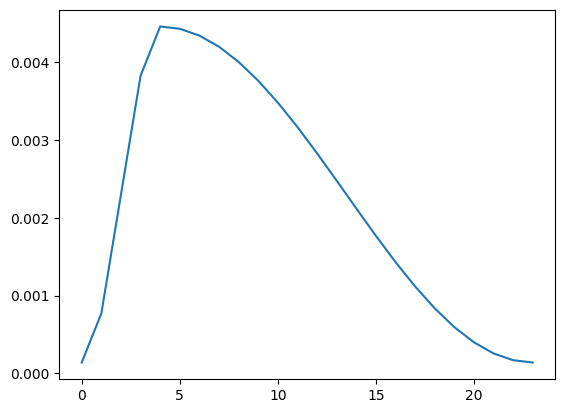

In [ ]:
lr_list = []
key = "Custom_Resnet_FC"
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), best_lr, nesterov=True, weight_decay=1e-4, momentum = 0.8)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                  max_lr=best_lr,
                  total_steps=24,
                  steps_per_epoch = len(train_loader),
                  epochs=24,
                  pct_start=5/24,
                  cycle_momentum=False,
                  div_factor=32,
                  final_div_factor=1,
                  anneal_strategy ='cos',
                  #annihilation_frac=0,
                  last_epoch=-1)
 # print('='*30 + f' div: {i} ' + '='*30)
epochs = 24
print('='*20 + 'START' + '='*20)
test = Test(model, device, test_loader, key)
train = Train(model, device, train_loader, optimizer, l1=0)
for epoch in range(epochs):
    print('='*20 + f' EPOCH: {epoch+1} ' + '='*20)
    train.train(epoch)
    lr_list.append(optimizer.param_groups[0]['lr'])
    print('\n Current LR:',lr_list[epoch])
    test.test()
    scheduler.step() #Have to give the val_loss or val_accuracy here. The metric on which we can to check
    #test.test()
  #fig, axs = plt.subplots(4,1,figsize=(15,10))
plt.plot(lr_list)


# Result Analysis

In [ ]:
import Packages.plot
from Packages.plot import mis, gen_cam, plot_pred_cam, plot_act_cam
from Packages.graphs import acc_loss, testvtrain, class_acc

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Load Best Model

In [ ]:
key = "Custom_Resnet_FC"
best_model = model_custom_ResNET(params = False).to(device)
best_model.load_state_dict(torch.load(f'/content/drive/MyDrive/Fellowship AI/S11_superconvergence/Classifiers/classifier_{key}.pt'))
best_model.eval()
print('Best Model Loaded!')

Best Model Loaded!


In [ ]:
mis(best_model, device, test_loader, 16)

Directory  /content/mis_class/ and /content/mis_class/images  already exists

Test set: Average loss: 0.1013, Accuracy: 1000/1020 (98.04%)

torch.Size([20, 3, 224, 224])


In [ ]:
Packages.plot.true_list

['Carnation',
 'Windflower',
 'Canterbury Bells',
 'Corn Poppy',
 'Balloon Flower',
 'Trumpet Creeper',
 'Azalea',
 'Sweet Pea',
 'Canterbury Bells',
 'Osteospermum',
 'Garden Phlox',
 'Canterbury Bells',
 'Canna Lily',
 'Bearded Iris',
 'Mexican Petunia',
 'Garden Phlox']

In [ ]:
layers = ['layer1','layer2','layer3', 'layer4',]
for layer in layers:
  gen_cam(best_model, layer) #GradCAM for Misclassified w.r.t Predicted Class
  gen_cam(best_model, layer, class_idx= Packages.plot.true_list) #GradCAM for Misclassified w.r.t Actual Class

Directory  /content/result_pred/  already exists
Directory  /content/heatmap_pred/  already exists


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Directory  /content/result_act/  already exists
Directory  /content/heatmap_act/  already exists
Directory  /content/result_pred/  already exists
Directory  /content/heatmap_pred/  already exists
Directory  /content/result_act/  already exists
Directory  /content/heatmap_act/  already exists
Directory  /content/result_pred/  already exists
Directory  /content/heatmap_pred/  already exists
Directory  /content/result_act/  already exists
Directory  /content/heatmap_act/  already exists
Directory  /content/result_pred/  already exists
Directory  /content/heatmap_pred/  already exists
Directory  /content/result_act/  already exists
Directory  /content/heatmap_act/  already exists


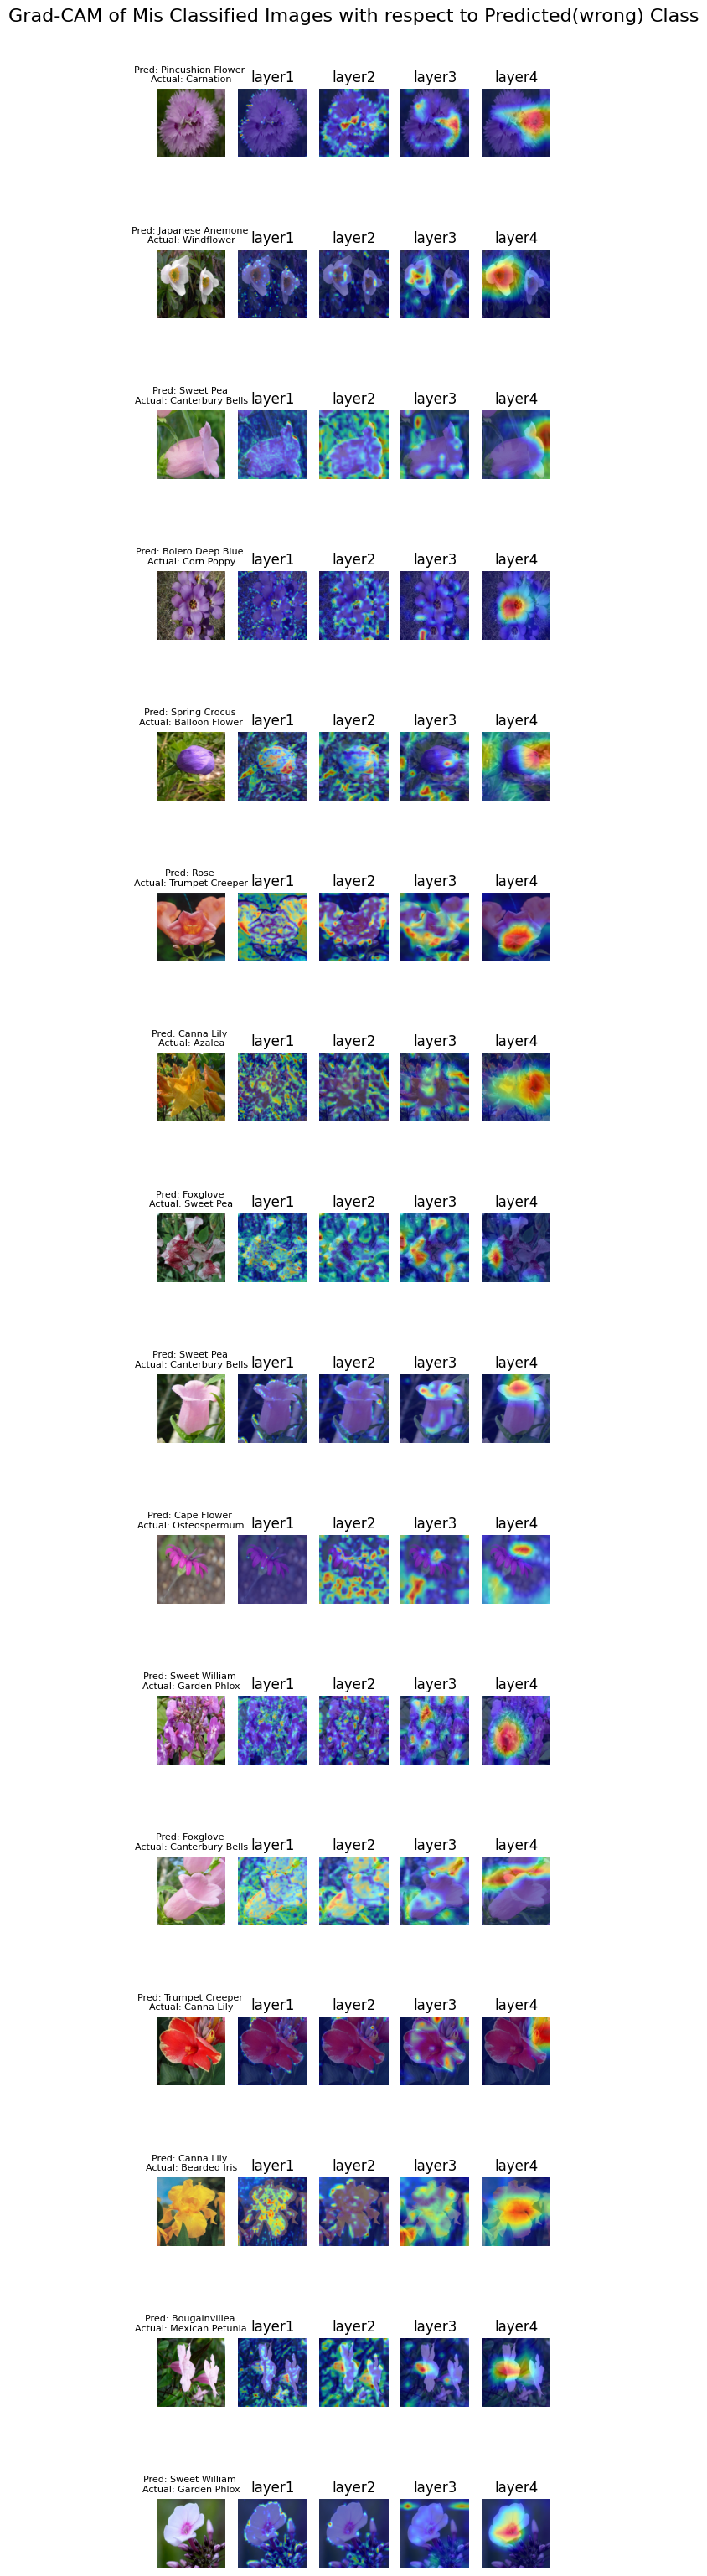

In [ ]:
plot_pred_cam(16, layers, 4)

In [ ]:
plot_act_cam(16,layers, 4)

In [ ]:
acc_loss(train, test)

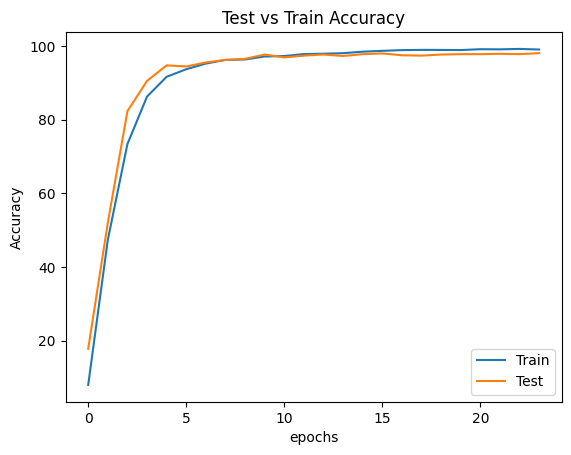

In [ ]:
testvtrain(train, test)

In [ ]:
class_acc(model, device, test_loader)

Accuracy of pink primrose : 100 %
Accuracy of hard-leaved pocket orchid : 100 %
Accuracy of canterbury bells : 60 %
Accuracy of sweet pea : 90 %
Accuracy of english marigold : 100 %
Accuracy of tiger lily : 100 %
Accuracy of moon orchid : 100 %
Accuracy of bird of paradise : 100 %
Accuracy of monkshood : 100 %
Accuracy of globe thistle : 100 %
Accuracy of snapdragon : 100 %
Accuracy of colt's foot : 100 %
Accuracy of king protea : 100 %
Accuracy of spear thistle : 100 %
Accuracy of yellow iris : 100 %
Accuracy of globe-flower : 100 %
Accuracy of purple coneflower : 100 %
Accuracy of peruvian lily : 100 %
Accuracy of balloon flower : 90 %
Accuracy of giant white arum lily : 100 %
Accuracy of fire lily : 100 %
Accuracy of pincushion flower : 100 %
Accuracy of fritillary : 100 %
Accuracy of red ginger : 100 %
Accuracy of grape hyacinth : 100 %
Accuracy of corn poppy : 90 %
Accuracy of prince of wales feathers : 100 %
Accuracy of stemless gentian : 100 %
Accuracy of artichoke : 100 %
Accur

In [ ]:
optimizer.param_groups[0]['lr']

0.0001689261466337119